Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [1]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='pyproj')
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from sklearn.linear_model import LinearRegression
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.svm import LinearSVC

In [2]:
def crop_trips_by_coordinates(dataframe):
    dataframe = dataframe[dataframe["start_lat"] > 33].copy()
    dataframe = dataframe[dataframe["end_lat"] > 33].copy()
    dataframe = dataframe[dataframe["start_lon"] < -116].copy()
    dataframe = dataframe[dataframe["end_lon"] < -116].copy()
    return dataframe

def generate_datetime_features(dataframe):
    dataframe["start_time"] = pd.to_datetime(dataframe["start_time"])
    dataframe["end_time"] = pd.to_datetime(dataframe["end_time"])
    dataframe["trip_duration_in_minutes"] = dataframe["end_time"] - dataframe["start_time"]
    df = dataframe[dataframe["trip_duration_in_minutes"] > pd.Timedelta(minutes=0)].copy()
    df = df[df["trip_duration_in_minutes"] < pd.Timedelta(hours=24)]
    df["trip_duration_in_minutes"] = df["trip_duration_in_minutes"] / pd.Timedelta(minutes=1)
    df["year"] = df["start_time"].dt.year
    df["month"] = df["start_time"].dt.month
    df["day_of_week"] = df["start_time"].dt.dayofweek
    df["hour"] = df["start_time"].dt.hour
    df = df.sort_values("start_time")
    return df

def add_coordinate_features(dataframe):
    df = dataframe.copy()
    df['StartCoordinate'] = list(zip(df.start_lat, df.start_lon))
    df['EndCoordinate'] = list(zip(df.end_lat, df.end_lon))
    return df

def engineer_data(dataframe):
    # Copy input DataFrame
    engineered_data = dataframe.copy()
    # Apply coarse spatial filter based on coordinates
    engineered_data = crop_trips_by_coordinates(engineered_data)
    # Remove duplicate trips
    engineered_data.drop_duplicates(["trip_id"], inplace=True)
    # Generate datetime features such as trip day of week and hour of day
    engineered_data = generate_datetime_features(engineered_data)
    # Crop unneccessary columns
    engineered_data = engineered_data[["trip_id","start_time","end_time","start_lat","start_lon","end_lat","end_lon","bike_id","trip_route_category","passholder_type","trip_duration_in_minutes","year","month","day_of_week","hour"]].copy()
    # Dictionary to map Los Angeles user classes to simplified "Customer" vs. "Subscriber" dichotomy
    simplified_dictionary = {"Annual Pass": "Subscriber", 
                             "Flex Pass":"Subscriber", 
                             "Monthly Pass": "Subscriber", 
                             "One Day Pass": "Customer", 
                             "Walk-up":"Customer"}
    engineered_data["UserType"] = engineered_data["passholder_type"].map(simplified_dictionary)
    engineered_data['DayType'] = engineered_data['day_of_week'].apply(lambda x: 'Weekday' if x <= 4 else 'Weekend')
    return engineered_data

def merge_trips_with_ancillary_data(dataframe):
    
    starts_gdf = gpd.GeoDataFrame(dataframe.drop(["end_lon","end_lat"], axis=1), geometry=gpd.points_from_xy(dataframe.start_lon, dataframe.start_lat))
    ends_gdf = gpd.GeoDataFrame(dataframe.drop(["start_lon","start_lat"], axis=1), geometry=gpd.points_from_xy(dataframe.end_lon, dataframe.end_lat))
    
    starts_gdf.crs = "EPSG:4326"
    ends_gdf.crs = "EPSG:4326"
    
    census_places = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/census-places-2012.geojson"
    census_tracts = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/census-tracts-2012.geojson"
    neighborhoods = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-current.geojson"
    regions = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-regions-current.geojson"

    census_places_gdf = gpd.read_file(census_places)
    census_tracts_gdf = gpd.read_file(census_tracts)
    neighborhoods_gdf = gpd.read_file(neighborhoods)
    regions_gdf = gpd.read_file(regions)
    
    census_places_gdf = census_places_gdf.to_crs("EPSG:4326")
    census_tracts_gdf = census_tracts_gdf.to_crs("EPSG:4326")
    neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:4326")
    regions_gdf = regions_gdf.to_crs("EPSG:4326")
    
    census_places_gdf = census_places_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1)
    census_places_gdf.rename(columns={"name":"CensusPlace"}, inplace=True)
    
    census_tracts_gdf = census_tracts_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1)
    census_tracts_gdf.rename(columns={"name":"CensusTract"}, inplace=True)
    
    neighborhoods_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1, inplace=True)
    neighborhoods_gdf.rename(columns={"name":"Neighborhood"}, inplace=True)

    regions_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1, inplace=True)
    regions_gdf.rename(columns={"name":"Region"}, inplace=True)

    starts_census_tracts_gdf = gpd.sjoin(starts_gdf, census_tracts_gdf, how="left")
    starts_census_places_gdf = gpd.sjoin(starts_gdf, census_places_gdf, how="left")
    starts_neighborhoods_gdf = gpd.sjoin(starts_gdf, neighborhoods_gdf, how="left")
    starts_regions_gdf = gpd.sjoin(starts_gdf, regions_gdf, how="left")
    
    starts_regions_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_neighborhoods_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_census_places_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_census_tracts_gdf.drop(["index_right"], axis=1, inplace=True)
    
    ends_census_tracts_gdf = gpd.sjoin(ends_gdf, census_tracts_gdf, how="left")
    ends_census_places_gdf = gpd.sjoin(ends_gdf, census_places_gdf, how="left")
    ends_neighborhoods_gdf = gpd.sjoin(ends_gdf, neighborhoods_gdf, how="left")
    ends_regions_gdf = gpd.sjoin(ends_gdf, regions_gdf, how="left")
    
    ends_regions_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_neighborhoods_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_census_places_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_census_tracts_gdf.drop(["index_right"], axis=1, inplace=True)
    
    starts_with_boundaries = starts_regions_gdf.merge(starts_neighborhoods_gdf[["trip_id","Neighborhood"]], on="trip_id").merge(starts_census_places_gdf[["trip_id","CensusPlace"]], on="trip_id").merge(starts_census_tracts_gdf[["trip_id","CensusTract"]], on="trip_id")
    ends_with_boundaries = ends_regions_gdf.merge(ends_neighborhoods_gdf[["trip_id","Neighborhood"]], on="trip_id").merge(ends_census_places_gdf[["trip_id","CensusPlace"]], on="trip_id").merge(ends_census_tracts_gdf[["trip_id","CensusTract"]], on="trip_id")
    
    starts_with_boundaries_df = pd.DataFrame(starts_with_boundaries.drop(["geometry"], axis=1))
    ends_with_boundaries_df = pd.DataFrame(ends_with_boundaries[["trip_id","Region","Neighborhood","CensusPlace","CensusTract"]])
    
    trips_with_boundaries_df = starts_with_boundaries_df.merge(ends_with_boundaries_df, on="trip_id", suffixes=("_start","_end"))
        
    return trips_with_boundaries_df



In [3]:
# Use wildcard to read-in all csv files in folder
filepath = glob("/home/alex/data/la-metro-bike-share/*.csv")

# Use low memory option to avoid specifying datatypes explicitly
dataframes = [pd.read_csv(f, low_memory=False) for f in filepath]

# Concatenate each individual CSV dataframe into a single dataframe
df = pd.concat(dataframes)

# Engineer data
trip_data = engineer_data(df)

# Merge trip data with ancillary boundary data
trips_with_boundaries = merge_trips_with_ancillary_data(trip_data)

# Engineer a new feature
trips_with_boundaries["Stays in same CensusTract"] = trips_with_boundaries["CensusTract_start"] == trips_with_boundaries["CensusTract_end"]

# Return distribution of engineered feature
trips_with_boundaries["Stays in same CensusTract"].value_counts(normalize=True)*100


False    74.297108
True     25.702892
Name: Stays in same CensusTract, dtype: float64

In [4]:
data_for_predictions = trips_with_boundaries.drop(["trip_id","start_time","end_time","trip_duration_in_minutes","bike_id", "trip_route_category","Region_end","Neighborhood_end","CensusPlace_end","CensusTract_end"], axis=1)

data_for_predictions.head()


,start_lat,start_lon,passholder_type,year,month,day_of_week,hour,UserType,DayType,Region_start,Neighborhood_start,CensusPlace_start,CensusTract_start,Stays in same CensusTract
0,34.056610,-118.23721,Monthly Pass,2016,7,3,4,Subscriber,Weekday,Central L.A.,Downtown,Los Angeles,06037206020,True
1,34.056610,-118.23721,Monthly Pass,2016,7,3,6,Subscriber,Weekday,Central L.A.,Downtown,Los Angeles,06037206020,True
2,34.052898,-118.24156,Flex Pass,2016,7,3,10,Subscriber,Weekday,Central L.A.,Downtown,Los Angeles,06037207400,True
3,34.052898,-118.24156,Flex Pass,2016,7,3,10,Subscriber,Weekday,Central L.A.,Downtown,Los Angeles,06037207400,True
4,34.049889,-118.25588,Walk-up,2016,7,3,12,Customer,Weekday,Central L.A.,Downtown,Los Angeles,06037207710,True


In [49]:
train, test = train_test_split(
    data_for_predictions, 
    train_size=0.80, 
    test_size=0.20, 
    random_state=42)

train, validate = train_test_split(
    train, 
    train_size=0.80, 
    test_size=0.20, 
    random_state=42)

In [50]:
train.shape, validate.shape, test.shape

((579503, 14), (144876, 14), (181095, 14))

In [51]:
# The status_group column is the target
target = 'Stays in same CensusTract'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality.index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
features

['start_lat',
 'start_lon',
 'year',
 'month',
 'day_of_week',
 'hour',
 'passholder_type',
 'UserType',
 'DayType',
 'Region_start',
 'Neighborhood_start',
 'CensusPlace_start',
 'CensusTract_start']

Baseline accuracy, precision, and recall for majority classifier

In [52]:
y_train = train[target]
y_validate = validate[target]
y_test = test[target]

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print("\n",classification_report(y_train, y_pred))

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



               precision    recall  f1-score   support

       False       0.74      1.00      0.85    430750
        True       0.00      0.00      0.00    148753

    accuracy                           0.74    579503
   macro avg       0.37      0.50      0.43    579503
weighted avg       0.55      0.74      0.63    579503



In [53]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]
X_test = test[features]
y_test = test[target]

In [54]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=8)
)

pipeline.fit(X_train, y_train)

print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_validate, y_validate))
y_pred = pipeline.predict(X_validate)
print("\n", classification_report(y_validate, y_pred))

Train Accuracy 0.7571211883286195
Validation Accuracy 0.7557773544272344

               precision    recall  f1-score   support

       False       0.76      0.99      0.86    107454
        True       0.71      0.09      0.16     37422

    accuracy                           0.76    144876
   macro avg       0.73      0.54      0.51    144876
weighted avg       0.75      0.76      0.68    144876



In [55]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=8)
)

pipeline.fit(X_train, y_train)

print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_validate, y_validate))
y_pred = pipeline.predict(X_validate)
print("\n",classification_report(y_validate, y_pred))

Train Accuracy 0.9107631884563151
Validation Accuracy 0.7649507164747784

               precision    recall  f1-score   support

       False       0.82      0.87      0.85    107454
        True       0.55      0.47      0.51     37422

    accuracy                           0.76    144876
   macro avg       0.69      0.67      0.68    144876
weighted avg       0.75      0.76      0.76    144876



In [56]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(random_state=8, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_validate, y_validate))
y_pred = pipeline.predict(X_validate)
print("\n",classification_report(y_validate, y_pred))

Train Accuracy 0.9107407554404378
Validation Accuracy 0.779107650680582

               precision    recall  f1-score   support

       False       0.83      0.88      0.86    107454
        True       0.59      0.48      0.53     37422

    accuracy                           0.78    144876
   macro avg       0.71      0.68      0.69    144876
weighted avg       0.77      0.78      0.77    144876



In [58]:
print ('Testing Accuracy', pipeline.score(X_test, y_test))
y_pred = pipeline.predict(X_test)
print("\n",classification_report(y_test, y_pred))

Testing Accuracy 0.7792484607526436

               precision    recall  f1-score   support

       False       0.83      0.88      0.86    134537
        True       0.59      0.48      0.53     46558

    accuracy                           0.78    181095
   macro avg       0.71      0.68      0.69    181095
weighted avg       0.77      0.78      0.77    181095



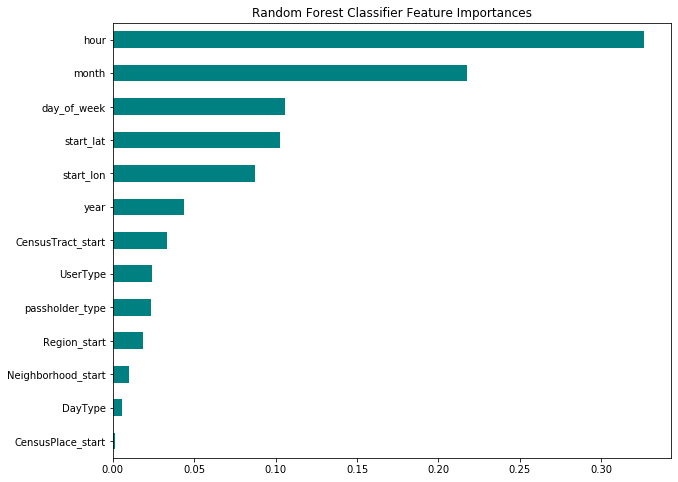

In [74]:
model = pipeline.named_steps['randomforestclassifier']

encoder = pipeline.named_steps["ordinalencoder"]

encoded_columns = encoder.transform(X_validate).columns

importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(10,8))
importances.sort_values().plot(kind="barh", color="teal")
plt.title("Random Forest Classifier Feature Importances")
plt.show()

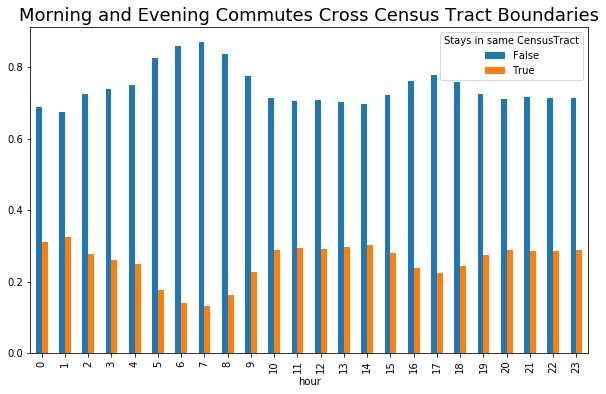

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
data_for_predictions.groupby("hour")["Stays in same CensusTract"].value_counts(normalize=True).unstack().plot(kind="bar", ax=ax)
plt.title("Morning and Evening Commutes Cross Census Tract Boundaries", size=18)
plt.show()